# **<center>Machine Learning and Finance </center>**


## <center> Optional Reading </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://mlfbg.github.io/MachineLearningInFinance/">
    <img src="https://drive.google.com/uc?export=view&id=1gmxxmwCR1WXK0IYtNqvE4QXFleznWqQO" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1ig5RFFtx8NTebwqZr-WHJYGYv7zZsiL5?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>

In this Lecture we will deal with the following topics:

* The Vanishing/Exploding Gradients Problems
* Nonsaturating Activation Functions
* Batch Normalization
* Gradient Clipping 
* Transfer Learning


# Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [ ]:
# Access to drive
from google.colab import drive 
drive.mount('/content/gdrive')
from IPython.display import Image # for showing graphs from the lectures
plt.style.use('dark_background') # to adapt the colors to a dark background

Mounted at /content/gdrive


# Vanishing/Exploding Gradients Problem

* **Vanishing Gradient Problem**: As gradients get smaller and smaller as the algorithm progresses down the lower layers, the first layers tend to keep unchaged. We call this the vanishing gradient problem.

* **Exploding Gradient Problem**: When the gradients grow bigger and bigger, layers get large weight updates, which results in the exploding gradient problem. 

Deep Neural Networks suffer from unstable gradients: Different layers learn at widely different speeds. 

This difficulty was explained in the paper: [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (Xavier Glorot and Yoshua Bengio). 

Ideas of the paper: 
  * Combination of sigmoid and the weight initialization used at that time: Normal distribution with mean of 0 et std of 1). They conclude that with this scheme the variance of the output of each layer is much greater than its input.  
  * Bengio and Glorot propose a way of overcoming the problem in both direction (forward and backward). They suggested that the variance of the output of each layer should be equal to the variance of the input. The initialization strategy is called **Xavier initialization** or **Glorot Initialization**. 


  * We call the number of the inputs of a layer $\text{fan}_{\text{in}}$ and the number of the outputs of a layer $\text{fan}_{\text{out}}$

  * The Glorot Initialization: Normal distribution with mean 0 and variance equal to $\sigma^2 = \frac{1}{\text{fan}_{\text{avg}}} = \frac{2}{\text{fan}_{\text{in}} + \text{fan}_{\text{in}}}$ or Uniform distribution between -r and +r with $r = \sqrt{\frac{3}{\text{fan}_{\text{avg}}}}$

Other papers proposed other strategies for other activation functions. 

The all differ by the scale of the variance and whether they use $\text{fan}_{\text{in}}$ or $\text{fan}_{\text{avg}}$


  * For **ReLu** and its variants we use the **He initialization**
  * for **SELU** we use the **LeCun initialization**


|  Initialization 	|  Activation Function 	|  $\sigma^2$ 	|
|---	|---	|---	|
|  Glorot 	|  None, tanh logistic, softmax 	|  $\frac{1}{\text{fan}_{\text{avg}}}$ |
|  He 	| ReLu and variants 	|  $\frac{2}{\text{fan}_{\text{in}}}$   	|
|  LeCun	|  SELU 	|  $\frac{1}{\text{fan}_{\text{in}}}$ 	|

By default, Keras uses **Glorot** initialization with a uniform distribution. 

When creating a layer, we can change the initialization be setting `kernel_initializer = "he_uniform"`or `kernel_initializer = "he_normal"` 

Moreover, if you want to use *He* initialization with a uniform distribution but based on $\frac{1}{\text{fan}_{\text{avg}}}$ instead of $\frac{1}{\text{fan}_{\text{in}}}$, we can use `VarianceScaling` from `keras.initializers`









Q1. Print the initializers in `keras.initializers`

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

Q2. **Custom Initialization**: Define a Dense layer called `dense_layer` with 10 neurons, a sigmoid activation function and the following initialization:

* uniform distribution 
* $\sigma^2 = \frac{2}{\text{fan}_{avg}}$

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import VarianceScaling

initializer = VarianceScaling(scale = 2.,
                             mode = "fan_avg",
                             distribution = "uniform")

dense_layer = Dense(10, activation = "sigmoid", kernel_initializer = initializer)

# Nonsaturating Activation Functions

## Description

The previous paper highlited that a poor choice of activation functions might results in very instable gradients. 

Other activation functions behave much better in practice, like the **ReLu** activation function, mostly because it doesn't saturate. However, this activation function suffers from a problem called **dying ReLu**. 

The problem with the ReLu is that sometimes, we find ourserlves in a situation where the neuron is only outputting zero all the time since the weighted sum of its input is negative for all data points in the training set. In that case, Gradient Descent doesn't affect it anymore (since the gradient of the ReLu is zero when its input is negative). 

A way of solving this issue is to use the **Leaky ReLu** defined as follows:

$\text{leaky_relu}_{\alpha}(x) = \max(\alpha x, x)$

$\alpha$ represents how much the function leaks (typically 0.01)

For more details, see the reference [Empirical Evaluation of Rectified Activations in Convolution Network](https://arxiv.org/pdf/1505.00853.pdf)

Q3. Plot the leaky relu function 

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


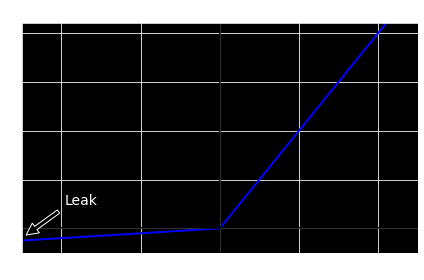

In [ ]:
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

Q4. Show all the activation function containing "ReLu"

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Q5. Create a small model composed of 
* an input layer. The input data should of shape (None, 784)
* A hidden dense layer of size 64 with the He normal initialization and the leaky relu activation (with alpha = 0.2)
* A final dense layer with 10 neurons and the "He initialization", use the LeakyReLU as an activation function by 

In [ ]:
from tensorflow.keras.layers import Dense, LeakyReLU, InputLayer
from tensorflow.keras.models import Sequential

model = Sequential([
                    InputLayer(input_shape=(784,)),
                    Dense(64, kernel_initializer="he_normal"),
                    LeakyReLU(alpha=0.2),
                    Dense(10, activation="softmax")
]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


The [previous paper](https://arxiv.org/pdf/1505.00853.pdf) also evaluated refinements of the leaky ReLu activation function: 

  * The **randomized leaky ReLu (RReLu)** where $\alpha$ is picked randomly in a given range during training and is fixed to an average value on the test set. The RReLu acts like a regulizer. 

  * The **parametric leaky ReLy (PReLu)** where $\alpha$ is authorized to be learned during training. PReLu strongly outperforms ReLu on large image datasets, but it runs the risk of overfitting on small datasets. 

Another activation function was introduced in the paper [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852.pdf): The **exponential linear unit(ELU)** defined as follows:

$
\text{ELU}_{\alpha}(x) =\left\lbrace
\begin{array}{ll}
\alpha(\exp(x) - 1) & \mbox{if x < 0}\\
x & \mbox{else.}
\end{array}
\right.$$
$

The ELU activation function has the following advantages:
  * It takes on values when $x<0$, which helps alleviate the vanishing gradient problem. 
  * We can tweak $\alpha$ as any other hyperparameter (usually $\alpha = 1$). 
  * When $\alpha = 1$, the function is smooth everywhere, which helps speed up the Gradient Descent since it has no reason to bounce as much to the left and right of 0. 
  * One drawback of the ELU is that it is slower to compute as it involves the exponential. 

Q6. Plot the ELU activation function for $\alpha =1$

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


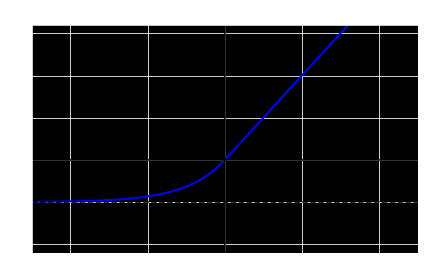

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building the layer. 

In [ ]:
keras.layers.Dense(10, activation="elu")

In 2017, Günter Klambauer introduced the  **Scaled exponential linear unit (SELU)** activation function in the paper [Self-Normalizing Neural Networks](https://arxiv.org/pdf/1706.02515.pdf).

It is a scaled version of the ELU activation function.

The authors proved the following result: 

**IF**:
  * The network is a sequence of Dense layers 
  * The input features are standardized
  * Every hidden layer weights must be initialized with **LeCun initialization** (in Keras `kernel_initializer = "lecun_normal"`)

Then, the paper guarentees self-normalization.

NB: The researchers have noted that the SELU can also improve the performance with convolutional layers. 

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


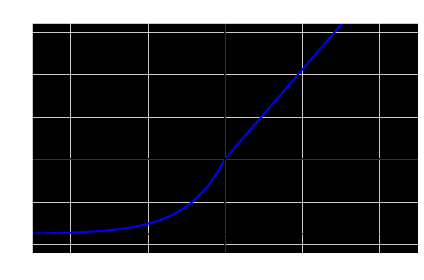

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

Let's try it on an example using numpy and TensorFlow

Q7. Create a network composed of 1000 layers of random size in the range (100 - 200)
Use the SeLU activation function and print the mean and the standard deviation of the output of each layer in the Forward Propagation


In [ ]:
np.random.seed(42) # To fix the seed
N = 1000 # Total number of samples
D = 100 # Dimensionality of data
layers_size = [D] + list(np.random.choice(np.arange(100, 200), 500))

# First We need Standardized inputs
Z = np.random.randn(N, D)

# Forward 
for i in range(len(layers_size)-1):
  # fan_in 
  fan_in = layers_size[i]
  fan_out = layers_size[i+1]
  # Weight matrix
  W = (1/np.sqrt(fan_in))*np.random.randn(fan_in, fan_out)
  # Output vector 
  Z = selu(Z.dot(W))
  # mean - variance 
  mean = np.mean(Z, axis = 0).mean()
  std = np.std(Z, axis = 0).mean()
  if i %100 == 0:
    print("iteration: {}, mean: {}, std: {}".format(i, mean, std))

iteration: 0, mean: 0.00047447853265880727, std: 0.9954468189015464
iteration: 100, mean: 0.0136322998843944, std: 0.9376915954848599
iteration: 200, mean: -0.034286102997599446, std: 0.9301034404675229
iteration: 300, mean: 0.010629906401873498, std: 0.9387118052183289
iteration: 400, mean: 0.0023778943432034294, std: 0.9218062992095829


Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Which activation function should we use for Deep Neural Networks? 

In general SELU > ELU > Leaky ReLU (and its refinements) > ReLU > tanh > logit

If we care about the speed, we should focus more about the leaky relu. 

If we have GPUs, we can use cross validation to evaluate other activation functions like PReLU and RReLU



## Illustration

Q8. A basic example

* Load the Fashion MNIST dataset and preprocess it
* Create an architecture based on 100 dense layers:
  * with the ReLU activation function
  * with the PReLU activation function
  * with the SeLU activation function

Which one performs better ? 

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model_relu = keras.models.Sequential()
model_relu.add(keras.layers.InputLayer(input_shape=(28, 28,)))
model_relu.add(keras.layers.Flatten(input_shape = (28, 28)))
for i in range(100):
  model_relu.add(keras.layers.Dense(100, activation = "relu", kernel_initializer="he_normal"))
model_relu.add(keras.layers.Dense(10, activation = "softmax"))
                                  
model_relu.compile(loss = "sparse_categorical_crossentropy",
                   optimizer = keras.optimizers.SGD(lr=1e-3),
                   metrics = ["accuracy"])
model_relu.fit(X_train, y_train,
               epochs = 10,
               validation_split = 0.2,
               verbose = 1)

Epoch 1/10
1500/1500 [==============================] - 25s 15ms/step - loss: 1.9771 - accuracy: 0.2329 - val_loss: 1.3709 - val_accuracy: 0.4056
Epoch 2/10
1500/1500 [==============================] - 21s 14ms/step - loss: 1.2378 - accuracy: 0.4913 - val_loss: 1.0770 - val_accuracy: 0.5888
Epoch 3/10
1500/1500 [==============================] - 21s 14ms/step - loss: 1.0530 - accuracy: 0.5785 - val_loss: 0.8113 - val_accuracy: 0.6844
Epoch 4/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.8991 - accuracy: 0.6524 - val_loss: 0.7384 - val_accuracy: 0.7315
Epoch 5/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.7966 - accuracy: 0.6962 - val_loss: 0.6956 - val_accuracy: 0.7526
Epoch 6/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.7073 - accuracy: 0.7366 - val_loss: 0.6538 - val_accuracy: 0.7687
Epoch 7/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.7004 - accuracy: 0.7364 - val_loss: 0.6875 -

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model_prelu = keras.models.Sequential()
model_prelu.add(keras.layers.InputLayer(input_shape=(28, 28,)))
model_prelu.add(keras.layers.Flatten(input_shape = (28, 28)))
for i in range(100):
  model_prelu.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
  model_prelu.add(keras.layers.PReLU())
model_prelu.add(keras.layers.Dense(10, activation = "softmax"))
                                  
model_prelu.compile(loss = "sparse_categorical_crossentropy",
                   optimizer= keras.optimizers.SGD(lr=1e-3),
                   metrics = ["accuracy"])
model_prelu.fit(X_train, y_train,
               epochs = 10,
               validation_split = 0.2,
               verbose = 1)

Epoch 1/10
1500/1500 [==============================] - 39s 22ms/step - loss: 1.9848 - accuracy: 0.2385 - val_loss: 1.2688 - val_accuracy: 0.4482
Epoch 2/10
1500/1500 [==============================] - 31s 21ms/step - loss: 1.2629 - accuracy: 0.4645 - val_loss: 1.1475 - val_accuracy: 0.5082
Epoch 3/10
1500/1500 [==============================] - 33s 22ms/step - loss: 1.0594 - accuracy: 0.5663 - val_loss: 1.5925 - val_accuracy: 0.3702
Epoch 4/10
1500/1500 [==============================] - 31s 21ms/step - loss: 1.1042 - accuracy: 0.5411 - val_loss: 0.9684 - val_accuracy: 0.5812
Epoch 5/10
1500/1500 [==============================] - 32s 21ms/step - loss: 0.9737 - accuracy: 0.6031 - val_loss: 0.8947 - val_accuracy: 0.6354
Epoch 6/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.8618 - accuracy: 0.6552 - val_loss: 0.7330 - val_accuracy: 0.7290
Epoch 7/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.7558 - accuracy: 0.7160 - val_loss: 0.7633 -

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

mean =  X_train.mean(axis = 0, keepdims = True) 
std = X_train.std(axis = 0, keepdims = True)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

model_selu = keras.models.Sequential()
model_selu.add(keras.layers.InputLayer(input_shape=(28, 28,)))
model_selu.add(keras.layers.Flatten(input_shape = (28, 28)))
for i in range(100):
  model_selu.add(keras.layers.Dense(100, activation = "selu", kernel_initializer="lecun_normal"))
model_selu.add(keras.layers.Dense(10, activation = "softmax"))
                                  
model_selu.compile(loss = "sparse_categorical_crossentropy",
                   optimizer= keras.optimizers.SGD(lr=1e-3),
                   metrics = ["accuracy"])
model_selu.fit(X_train, y_train,
               epochs = 10,
               validation_split = 0.2,
               verbose = 1)

Epoch 1/10
1500/1500 [==============================] - 27s 16ms/step - loss: 1.5364 - accuracy: 0.4197 - val_loss: 0.8653 - val_accuracy: 0.6726
Epoch 2/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.7936 - accuracy: 0.7066 - val_loss: 0.7399 - val_accuracy: 0.7237
Epoch 3/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.6811 - accuracy: 0.7452 - val_loss: 0.7195 - val_accuracy: 0.7465
Epoch 4/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.6772 - accuracy: 0.7581 - val_loss: 0.5889 - val_accuracy: 0.7847
Epoch 5/10
1500/1500 [==============================] - 23s 16ms/step - loss: 0.5749 - accuracy: 0.7907 - val_loss: 0.5810 - val_accuracy: 0.7873
Epoch 6/10
1500/1500 [==============================] - 23s 16ms/step - loss: 0.5283 - accuracy: 0.8131 - val_loss: 0.5121 - val_accuracy: 0.8257
Epoch 7/10
1500/1500 [==============================] - 23s 16ms/step - loss: 0.4959 - accuracy: 0.8278 - val_loss: 0.5063 -

SeLU works clearly better

# Batch Normalization

## Description

Ioffe and Szegedy explained in their paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://proceedings.mlr.press/v37/ioffe15.pdf) that **Batch Normalization** (BN) considerably improved all the deep learning networks they experimented with, especially on ImageNet. 

Remarks: 
* The vanishing gradients problem was drastically reduced using BN. 
* It is possible to use saturating activation functions like sigmoid or tanh along with BN. 
* The networks are less sensitive to Weight Initialization with BN. 
* We can use bigger learning rates to speed up the training with BN. It is time consuming though as it adds some complexity to the model. 
* BN acts like a regulizer, reducing the need of other regularization techniques.

Let's now describe the process of BN. 

---
**Notations**:

We decompose our training data: $x_1, \dots, x_n$ into batches $\mathcal{B}_1, \dots, \mathcal{B}_M$ of size $n_\mathcal{B}$

$\forall m \in \{1, \dots, M \} \quad \mathcal{B}_m = \{ x_m^{(1)}, \dots, x_m^{(n_\mathcal{B})} \}$

Each $x_m^j$ is of dimension $D$ 

---
**Description of the algorithm**:

Input: Batches $\mathcal{B}_1, \dots, \mathcal{B}_M$ of size $n_\mathcal{B}$ such that $\forall m \in \{ 1, \dots, M \} \quad \mathcal{B}_m = \{ x_m^{(1)}, \dots,  x_m^{(n_{\mathcal{B}})} \}$ 

Output: Batches $\hat{\mathcal{B}}_1, \dots, \hat{\mathcal{B}}_M$ of size $n_\mathcal{B}$ such that $\forall m \in \{ 1, \dots, M \} \quad \mathcal{B}_m = \{ z_m^{(1)}, \dots,  z_m^{(n_{\mathcal{B}})} \}$ 

The algorithm:

For all $m\in \{1, \dots, M \}$:
  * Step 1: We calculate the mini-batch mean $\mu_{\mathcal{B}_m}$ and the mini-batch variance $\sigma_{\mathcal{B}_m}^2$ as follows:
  \begin{align}
  \mu_{\mathcal{B}_m} &= \frac{1}{n_\mathcal{B}} \sum\limits_{j=1}^{n_\mathcal{B}} x_m^{(j)} \\
  \sigma_{\mathcal{B}_m}^2 &= \frac{1}{n_\mathcal{B}} \sum\limits_{j=1}^{n_\mathcal{B}} (x_m^{(j)} - \mu_{\mathcal{B}_m}) \circ (x_m^{(j)} - \mu_{\mathcal{B}_m})
  \end{align}
  where $\circ$ stands for the Hadamard product.  
  * Step 2: We update the mini-batch mean and the mini-batch using EWMA to get: $\hat{\mu}_{\mathcal{B}_m}$ and $\hat{\sigma}_{\mathcal{B}_m}^2$ as follows:
  \begin{align}
  \hat{\mu}_{\mathcal{B}_m} &= \lambda_{\mu} \circ \hat{\mu}_{\mathcal{B}_{m-1}} + (1 - \lambda_{\mu}) \circ \mu_{\mathcal{B}_{m}} \\
  \hat{\sigma}_{\mathcal{B}_m}^2 &= \lambda_{\sigma} \circ \hat{\sigma}_{\mathcal{B}_{m-1}}^2 + (1 - \lambda_{\sigma}) \circ \sigma_{\mathcal{B}_{m}}^2  
  \end{align}
  * Step 3: We normalize our batch m:
  \begin{equation}
  \hat{x}_m^{(j)}[d] = \frac{x_m^{(j)}[d] - \hat{\mu}_{\mathcal{B}_m}[d]}{\sqrt{\hat{\sigma}_{\mathcal{B}_m}^2[d] + \epsilon}} \quad ( \text{for all} \  d\in \{1, \dots, D \} \ \text{for all} \  j\in \{1, \dots, n_\mathcal{B} \}) 
  \end{equation}
  with $\epsilon \approx 10^{-5}$ is just a smoothing parameter to avoid dividing by zero. 
  * Step 4: We scale and shift the previous output using two parameters $\gamma$ and $\beta$ estimated during the training
  \begin{equation}
  z_m^{(j)} = \gamma \circ \hat{x}_m^{(j)} + \beta \quad (\text{for all} \  j\in \{1, \dots, n_\mathcal{B} \})
  \end{equation}
---



The following figure summarizes all the steps: 

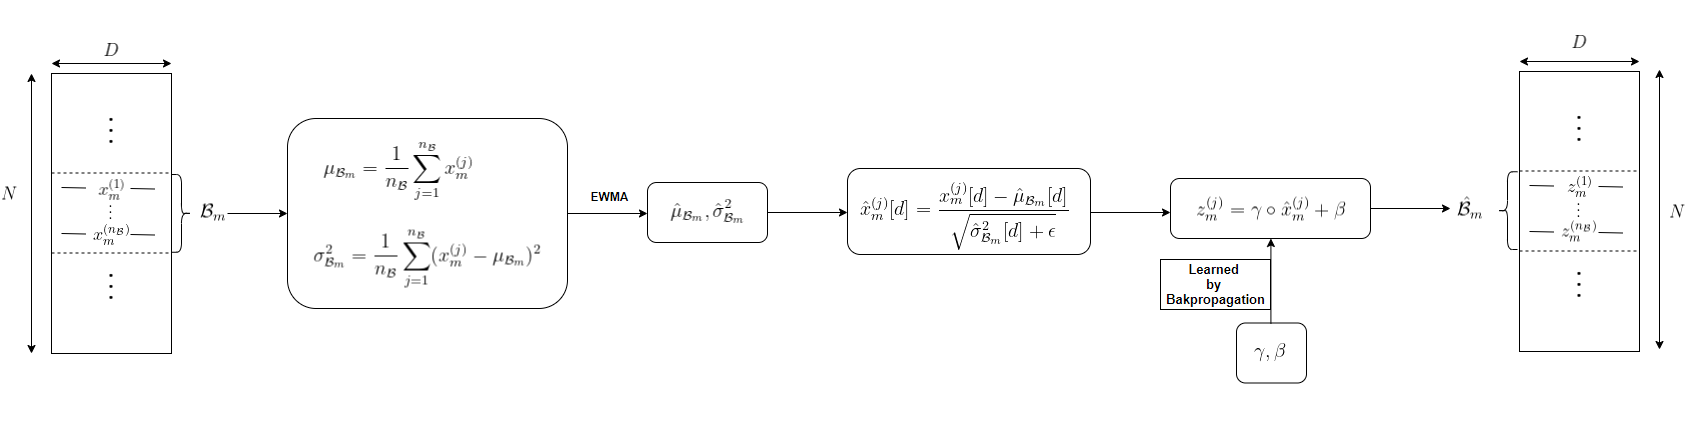

In [ ]:
# Access files from Google Drive
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_5/Reading/images/BatchNorm.PNG', width=1500) 

## Implementing Batch Normalization

To Implement Batch Normalization just import the layer from `tensorflow.keras.layers`. 

Q9. Create a basic model with the following layers:

* Flatten layer to go from (N, 28, 28) to (N, 784)
* BN layer
* Dense layer with 256 neurons, elu activation function and He normal initialization
* BN layer
* Dense layer with 128 neurons, elu activation function and He normal intialization
* BN layer
* Dense layer with 10 neurons and the softmax activation function

Detail the parameters (trainable and non-trainable)

In [ ]:
from tensorflow.keras.layers import InputLayer, Flatten, BatchNormalization, Dense 
from tensorflow.keras.models import Sequential 

model = Sequential(
    [InputLayer(input_shape=(28, 28,)),
     Flatten(),
     BatchNormalization(),
     Dense(256, activation = "elu", kernel_initializer = "he_normal"),
     BatchNormalization(),
     Dense(128, activation = "elu", kernel_initializer = "he_normal"),
     BatchNormalization(),
     Dense(10, activation = "softmax")
     ])

model.summary(line_length=120)

Model: "sequential_15"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
flatten_12 (Flatten)                                  (None, 784)                                     0                 
________________________________________________________________________________________________________________________
batch_normalization_9 (BatchNormalization)            (None, 784)                                     3136              
________________________________________________________________________________________________________________________
dense_633 (Dense)                                     (None, 256)                                     200960            
________________________________________________________________________________________________________________________
batch_nor

* Flatten Layer : 0 parameters (just reshaping)
* BN : 3136 parameters which are $\gamma, \beta, \mu, \sigma$ for each dimension among the 784 dimensions 
  * This layer contains $4 \times 784 = 3136$ parameters. 
  * Among these parameters, those associated with $\mu, \sigma$ corresponding to the momentum of the moving average are non-trainable since they are not updated with back propagation $\rightarrow 2 \times 784 = 1568$ non trainable paramaters. 
  * The parameters associated with $\gamma, \beta$ are updated using back probagation $\rightarrow 2 \times 784 = 1568$ trainable parameters. 
* Dense: $200960 = 784 \times 256 + 256$ trainable parameters. 
* BN: 1024 parameters:
  * $256*2 = 512$ trainable parameters
  * $256*2 = 512$ non trainable parameters
* Dense: $32896 = 256 \times 128 + 128$ trainable parameters.
* BN: 512 parameters:
  * $128 \times 2 = 256$ trainable parameters
  * $128 \times 2 = 256$ non trainable parameters
* Dense: $1290 = 128 \times 10 + 10$ trainable parameters.

So, the total number of trainable parameters is : $237482 = 1568 + 200960 + 512 + 32896 + 256 + 1290$ and the total number of non trainable parameters is : $2336 = 1568 + 512 + 256$

Q10. Check the trainable and non-trainable parameters of one of the Batch Normalization layer. 

In [ ]:
parameter_info = [(parameter.name, parameter.trainable) for parameter in model.layers[1].variables]
for name, trainable in parameter_info:
  print("Name of the pramater: {}, Trainable: {}".format(name, trainable))

Name of the pramater: batch_normalization_9/gamma:0, Trainable: True
Name of the pramater: batch_normalization_9/beta:0, Trainable: True
Name of the pramater: batch_normalization_9/moving_mean:0, Trainable: False
Name of the pramater: batch_normalization_9/moving_variance:0, Trainable: False


Some authors suggest adding the BN before the activation function, rather than after. 

When using BN before the activation function, we can drop the bias term in the Dense layer as we use the "shift" parameter in BN. To that end, we need to add `use_bias = False` when creating the dense layer as follows: 

```
model.add(Dense(256, kernel_initializer = "he_normal", use_bias = False))
model.add(BatchNormalization())
model.add(Activation("elu"))
```

We can tweak the hyperparameters $\lambda_{\mu}, \lambda_{\sigma}$ representing the momentum for the mean and the variance terms. Usually, a good momentum value is close to 1. Typically the momentum can be equal to 0.9, 0.99 or 0.999 (larger datasets with smaller mini-batches require a momentum even closer to 1)


Another hyperparameter we can tweak is the axis that we want to normalize. It defaults to -1 (the last one). In our previous example, as we use the flattening layer, the tensor on which we apply the batch normalization is of shape (N, 784). Therefore, the normalization is applied across all the 784 dimensions. 

What if we want to perform the BN on a tensor of rank 3: $(N, d_1, d_2)$ for instance. If we use the default BN, it will normalise the tensor according to the last axis: If $x_1, \dots, x_m$ are the m data samples of shape $(d_1, d_2)$ in a particular batch, the mean on the mini-batch is of size $d_2$, it will be calculated as follows: 

$\mu_{\mathcal{B}} = \frac{1}{m \times d_1} \sum\limits_{u=1}^{m} \sum\limits_{i=1}^{d_1} x_u[i, :] \in \mathbb{R}^{d_2}$ (same story for the variance)

In other words, if our dataset is a set of images, all the pixels in a given column will be normalized with the same mean and standard deviation. 

If we want to perform the BN on each dimension of $d_1 \times d_2$, we should set `axis = [1, 2]`

In that case:
$\mu_{\mathcal{B}} = \frac{1}{m} \sum\limits_{u=1}^{m} x_u \in \mathbb{R}^{d_1 \times d_2}$ (same story for the variance)

To conclude this section about BN, a relatively recent paper [Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/pdf/1901.09321.pdf) achieved state-of-the-art performance on complex image classification tasks without BN, but by using a *fixed_update* weight initialization technique. 


 



# Gradient Clipping

To mitigate the exploding gradients problem, another method is to clip the gradients during backpropagation so that they never exceed some threshold. This threshold can be defined while defining the optimizer in terms of
  * value: `optimizer = tensorflow.keras.optimizers.SGD(clipvalue = 1.0)`. In that case, all the partial derivatives of the loss with respect to each trainable parameter will be clipped between -1 and 1. For instance a gradient vector of [-0.8, -3.5, 250.] becomes [-0.8, -1, 1.], which changes the direction of the gradient vector. 
  
  * norm: `optimizer = tensorflow.keras.optimizers.SGD(clipnorm = 1.0)`. In that case, it will keep the orientation of the vector but almost eliminate the dominated components. 

# Transfer Learning

## Description

Let's suppose we want to create a model for a particular task with few data samples. If we can find another model already trained on a bigger dataset with good performances and accomplishing a similar task, it can be useful to take the lower layers of the trained model, freeze their weights and fine tune additional hidden layers as shown in the following figure:

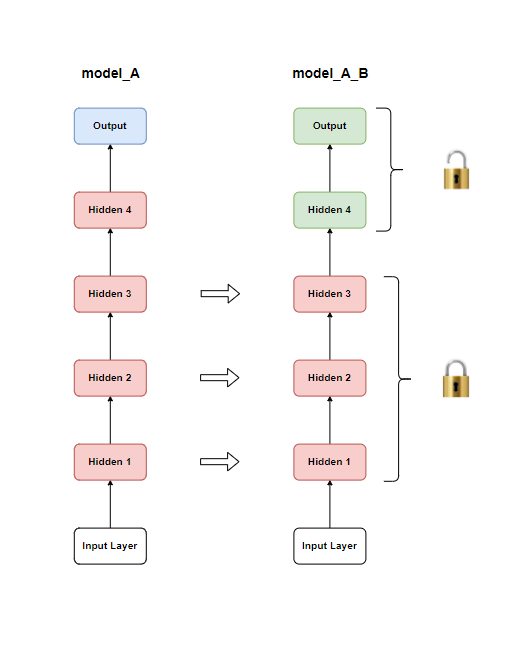

In [ ]:
Image(filename='./gdrive/My Drive/Colab Notebooks/Programming_Session_5/Reading/images/TransferLearning.PNG',  width=700) 

We usually fine tune the last layer (green layers in the figure) by using a normal learning rate. Then we can retrain the whole architecture using a much smaller learning rate. 

## Implementation on a simple example

Q11. Fine Tuning a model:

  * Q11.a) Load the fashion mnist dataset and separate it into two subdatasets
    * Dataset_A corresponds to the images associated with the labels \{0, 1, 2, 3, 4, 5, 6, 7 \}   
    * Dataset_B corresponds to the images associated with the labels 8 and 9

  * Q11.b) Train a model called model_A on Dataset A composed the 6 following layers:
      * Flatten layer.
      * Dense layer with 256 neurons, LeCun normal initialization and SeLU activation function.
      * Dense layer with 128 neurons, LeCun normal initialization and SeLU activation function.
      * Dense layer with 64 neurons, LeCun normal initialization and SeLU activation function.
      * Dense layer with 32 neurons, LeCun normal initialization and SeLU activation function.
      * Dense layer with 8 neurons, softmax activation function, default initialization. 

  * Q11.c) Save the model under the name `model_A.h5`.

  * Q11.d) Train a model called model_B on Dataset B composed of the same layers (except the last one because it is a binary classification problem). 

  * Q11.e) Create a new model called model_A_B as follows:
      * Load the model_A using `tensorflow.keras.load_model("model_A.h5")`
      * Take all the layers from model_A except the last. For that you will need to clone model_A using `tensorflow.keras.models.clone_model()`, to copy the weights from model_A using `model_A.get_wheights()` and set these weights in the new model (model_A_B) using `model_A_B.set_weights()`  
      * Freeze their weights by making each `layer` non-trainable (`layer.trainable = False`) 
      * Add an output layer 
      * Train the last layer using SGD and a learning rate of `1e-2` (default one)
      * Make the layers trainable (`layer.trainable = True`)
      * Train the whole architecture with a smaller learning rate `1e-4`
  * Q11.f) Compare model_A_B to model_B. What can you say ?




Q11.a) Loading the datasets A and B

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, InputLayer, Flatten 


# Split function
def split(X, y):
  """
  This function aims at separating the datasets into two subdatasets 
  Input: X : images of shape (N, 28, 28)
         y : labels from 0 to 9
  Output: (X_A, y_A): corresponding to labels other than 5 and 6
          (X_B, y_B): corresponding to the labels 5 and 6
  """
  indexes = (y==5) | (y==6) # indexes corresponding to the labels 8 and 9
  X_A, y_A = X[~indexes], y[~indexes] # dataset with labels other than 8 and 9
  y_A[y_A>6] -= 2  
  X_B, y_B = X[indexes], y[indexes] # dataset with label 8 and 9
  y_B = (y_B == 6).astype(np.float32) # turn the label 6 to 1 and the label 5 to 0 
  return (X_A, y_A), (X_B, y_B)

# Load the data

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
(X_A_train, y_A_train), (X_B_train, y_B_train) = split(X_train, y_train)
(X_A_test, y_A_test), (X_B_test, y_B_test) = split(X_test, y_test)

Q11.b) Training model A

In [ ]:
set(y_A_train)

{0, 1, 2, 3, 4, 5, 6, 7}

In [ ]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(42)
np.random.seed(42)
from tensorflow.keras.layers import Flatten, Dense, InputLayer, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD



# Define the model
model_A = Sequential()
model_A.add(InputLayer(input_shape = (28, 28, )))
model_A.add(Flatten())
for size in [256, 128, 64, 32]:
  model_A.add(Dense(size, activation = "relu"))
  model_A.add(BatchNormalization())
model_A.add(Dense(8, activation = "softmax"))
model_A.summary()

# Compile the model
model_A.compile(loss = "sparse_categorical_crossentropy",
                optimizer = SGD(learning_rate=1e-3),
                metrics = ["acc"])

# Fit the model to the data
model_A.fit(X_A_train, y_A_train,
            batch_size = 256, 
            epochs = 20,
            verbose = 1,
            validation_data = (X_A_test, y_A_test))

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 256)               200960    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_147 (Dense)            (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dense_148 (Dense)            (None, 64)                8256      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64)              

Q11.c) Savind model_A

In [ ]:
from tensorflow.keras.models import save_model, load_model
save_model(model_A, "model_A.h5")

Q11.d) Training model_B

In [ ]:
# Import Modules
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import InputLayer, Flatten, Dense
from tensorflow.keras.optimizers import SGD

# Fix the seed

# Define the model
model_B = Sequential()
model_B.add(InputLayer(input_shape = (28, 28,)))
model_B.add(Flatten())
for size in [256, 128, 64, 32]:
  model_B.add(Dense(size, activation = "selu", kernel_initializer = "lecun_normal"))
model_B.add(Dense(1, activation = "sigmoid"))
model_B.summary() 

# Compile the model
model_B.compile(loss = "binary_crossentropy",
                optimizer = SGD(learning_rate=1e-3),
                metrics = ["acc"])

# Fit the model to the data
model_B.fit(X_B_train, y_B_train,
            batch_size = 256,
            epochs = 20,
            validation_data = (X_B_test, y_B_test),
            verbose = 1) 

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_166 (Dense)            (None, 256)               200960    
_________________________________________________________________
dense_167 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_168 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_169 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_170 (Dense)            (None, 1)                 33        
Total params: 244,225
Trainable params: 244,225
Non-trainable params: 0
_______________________________________________

Q11.e) Training model_A_B

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

from tensorflow.keras.models import Sequential, load_model, clone_model
from tensorflow.keras.layers import InputLayer, Flatten, Dense
from tensorflow.keras.optimizers import SGD 

# Load model_A, clone it in terms of architecture and weights
print("Loading model_A...")
model_A = load_model("model_A.h5")
model_A_clone = clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

# Create model_A_B 
print("Creating model_A_B")
model_A_B = Sequential(model_A_clone.layers[:-2])
model_A_B.add(Dense(64, activation = "selu", kernel_initializer = "lecun_normal"))
model_A_B.add(Dense(1, activation = "sigmoid"))

# Freeze the layers coming from model_A
for layer in model_A_B.layers[:-4]:
  layer.trainable = False

# Compile the model 
model_A_B.compile(loss = "binary_crossentropy",
                  optimizer = SGD(learning_rate=1e-3),
                  metrics = ["acc"])


# Train the last layer
print("Training model_A_B")
model_A_B.fit(X_B_train, y_B_train, 
              batch_size = 256,
              epochs = 20,
              validation_data = (X_B_test, y_B_test),
              verbose = 1)

# Un-freeze the first layers
for layer in model_A_B.layers[:-4]:
  layer.trainable = True

# Re-train the whole architecture with a small learning rate
model_A_B.compile(loss = "binary_crossentropy",
                  optimizer = SGD(learning_rate = 1e-5),
                  metrics = ["acc"])

print("Re-training model_A_B")
model_A_B.fit(X_B_train, y_B_train, 
              batch_size = 256,
              epochs = 20,
              validation_data = (X_B_test, y_B_test),
              verbose = 1)

Loading model_A...
Creating model_A_B
Training model_A_B
Epoch 1/20
47/47 [==============================] - 1s 12ms/step - loss: 0.8867 - acc: 0.4594 - val_loss: 0.7888 - val_acc: 0.5835
Epoch 2/20
47/47 [==============================] - 0s 8ms/step - loss: 0.6709 - acc: 0.6121 - val_loss: 0.5815 - val_acc: 0.6985
Epoch 3/20
47/47 [==============================] - 0s 8ms/step - loss: 0.5330 - acc: 0.7435 - val_loss: 0.4632 - val_acc: 0.8050
Epoch 4/20
47/47 [==============================] - 0s 8ms/step - loss: 0.4326 - acc: 0.8359 - val_loss: 0.3888 - val_acc: 0.8775
Epoch 5/20
47/47 [==============================] - 0s 8ms/step - loss: 0.3664 - acc: 0.8948 - val_loss: 0.3369 - val_acc: 0.9095
Epoch 6/20
47/47 [==============================] - 0s 8ms/step - loss: 0.3220 - acc: 0.9163 - val_loss: 0.2986 - val_acc: 0.9270
Epoch 7/20
47/47 [==============================] - 0s 8ms/step - loss: 0.2839 - acc: 0.9344 - val_loss: 0.2687 - val_acc: 0.9360
Epoch 8/20
47/47 [==============

Q11.f) Both models (model_B and model_A_B) are good. It seems that Transfer Learning was not necessary after all. The reason for that is that Dense layers learn specific patters, and the ones learned in model_A are unlikely to be useful for model_A_B. Transfer Learning works much better with CNN which tend to learn feature detectors that are much more general. 

What to do when we have few labeled data ? 

* If your dataset contains a lot of unlabeled data, you can use an unsupervised algorithm (autoencoder - GANs) on your unlabeled data, then reuse the lower layers for your supervised task, and fine tune the final network. This technique is called **Unsupervised Pretraining**

* Another technique is to train a model on a similar task but with enough labeled data, then use the lower layers of this model. This technique is called **Pretraining on an Auxiliary task**.  For instance, if you want to create a system to recognize faces but with few pictures of each individual. You could create a data by gathering the pictures of a lot of people on the internet and train a neural network to detect whether or not two people are the same person. This model would necessarily learn good feature detectors and we might consider reusing its lower layers for our face classifier.  

# References

[Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

[Empirical Evaluation of Rectified Activations in Convolution Network](https://arxiv.org/pdf/1505.00853.pdf)

[Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852.pdf)

[Self-Normalizing Neural Networks](https://arxiv.org/pdf/1706.02515.pdf)

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](http://proceedings.mlr.press/v37/ioffe15.pdf)

[Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/pdf/1901.09321.pdf)